In [1]:
from sb_value_function_kwargs import fc_policy_kwargs, cnn_policy_kwargs, linear_policy_kwargs
from environments.stable_baselines_env import StableBaselineEnv
from environments.stable_baselines_env_linear import StableBaselineEnvLinear
from environments.stable_baselines_env_linear_history import StableBaselineEnvLinearHistory
from environments.stable_baselines_env_history import StableBaselineEnvHistory
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

In [2]:
allocator_name = "ff_bad"
#TODO: CHANGE BOTH POLICY KWARGS AND NET NAME
policy_kwargs = linear_policy_kwargs
net_name = "linear"
history_len = 5
env = StableBaselineEnvLinearHistory(allocator=allocator_name, page_size=256, history_len=history_len)


model = DQN("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, learning_rate=0.0001, device="cuda")
#model attributes
print(env.observation_space)
print(model.__dict__)

<class 'request_streams.ff_bad.FFBad'>
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Box(0.0, 257.0, (1, 15), float32)
{'policy_class': <class 'stable_baselines3.dqn.policies.DQNPolicy'>, 'device': device(type='cuda'), 'verbose': 1, 'policy_kwargs': {'net_arch': []}, 'num_timesteps': 0, '_total_timesteps': 0, '_num_timesteps_at_start': 0, 'seed': None, 'action_noise': None, 'start_time': 0.0, 'learning_rate': 0.0001, 'tensorboard_log': None, '_last_obs': None, '_last_episode_starts': None, '_last_original_obs': None, '_episode_num': 0, 'use_sde': False, 'sde_sample_freq': -1, '_current_progress_remaining': 1.0, '_stats_window_size': 100, 'ep_info_buffer': None, 'ep_success_buffer': None, '_n_updates': 0, '_custom_logger': False, 'env': <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x0000025B170246D0>, '_vec_normalize_env': None, 'observation_space': Box(0.0, 257.0, (1, 15), float32), 'action_space': Discrete(3), '

In [3]:
def mean_confidence_interval(data, confidence=0.95):
    n = data.shape[0]
    mean, std_err = np.mean(data), np.std(data) / np.sqrt(n)
    interval = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean - interval, mean + interval, mean

Training & Rollout of policy

Output()

100%|██████████| 100/100 [00:11<00:00,  7.57it/s]

Output()

100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Output()

19.220000000000027


100%|██████████| 100/100 [00:18<00:00,  4.72it/s]

Output()

19.27600000000003


100%|██████████| 100/100 [00:57<00:00,  1.72it/s]


Output()

12.995000000000026


 94%|█████████▍| 94/100 [00:07<00:00, 18.88it/s]

8.081000000000016


([<matplotlib.axis.XTick at 0x25b329003d0>,
 [Text(0, 0, 'best fit'), Text(1, 0, 'worst fit'), Text(2, 0, 'first fit')])

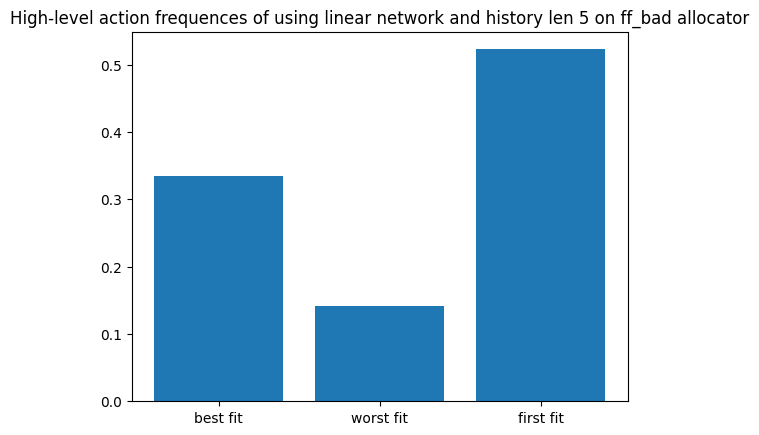

In [4]:
avg_return_per_session = []
action_counts_per_session = []
for train_and_rollout in range(5):
    model.learn(total_timesteps=20000, log_interval=20000, progress_bar=True)
    num_actions = 3
    obs, info = env.reset()
    i = 0
    rewards = []
    curr_reward = 0
    action_counts = [0] * num_actions
    total=100
    pbar = tqdm(total = total)
    while i < total:
        action, _states = model.predict(obs, deterministic=True)
        action_counts[action] += 1
        #print(action)
        obs, reward, terminated, truncated, info = env.step(action)
        if reward != .1 and reward != 0:
            print(reward)
        #print(reward != 1)
        curr_reward += reward
        if terminated or truncated:
            pbar.update(1)
            obs, info = env.reset()
            i += 1
            rewards.append(curr_reward)
            curr_reward = 0

    print(np.mean(rewards))
    avg_return_per_session.append(np.mean(rewards))
    action_counts_per_session.append(action_counts)

model_conf_int = mean_confidence_interval(np.array(avg_return_per_session))
model_conf_int = np.array(model_conf_int)

action_counts_per_session = np.array(action_counts_per_session)
action_counts_per_session = np.sum(action_counts_per_session, axis=0)
action_counts_per_session = action_counts_per_session / np.sum(action_counts_per_session)

plt.bar(np.arange(3), action_counts_per_session)
plt.title(f"High-level action frequences of using {net_name} network and history len {history_len} on {allocator_name} allocator")
plt.xticks(np.arange(3), ["best fit", "worst fit", "first fit"])

Baselines (best fit, worst fit, first fit)

In [5]:
conf_ints_baselines = []
for allocator in tqdm(range(3)):
    obs, info = env.reset()
    i = 0
    rewards = []
    curr_reward = 0
    while i < 100:
        #action, _states = model.predict(obs, deterministic=True)
        #print(action)
        obs, reward, terminated, truncated, info = env.step(allocator)
        if reward != .1 and reward != 0:
            print(reward)
        #print(reward != 1)
        curr_reward += reward
        if terminated or truncated:
            obs, info = env.reset()
            i += 1
            rewards.append(curr_reward)
            curr_reward = 0

    #print(allocator, mean_confidence_interval(np.array(rewards)))

    conf_ints_baselines.append(mean_confidence_interval(np.array(rewards)))

print(conf_ints_baselines)
conf_ints_baselines = np.array(conf_ints_baselines)
    

100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

[(19.18326995178473, 21.84073004821535, 20.51200000000004), (1.105150320492057, 1.3808496795079432, 1.243), (1.046065941661974, 1.3559340583380262, 1.201)]


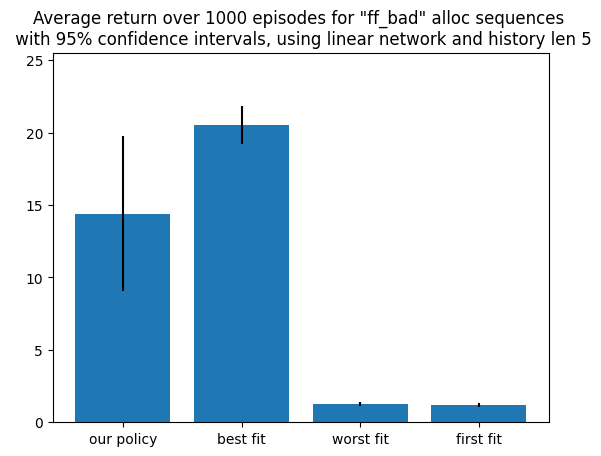

100%|██████████| 100/100 [00:21<00:00, 18.88it/s]

: 

In [6]:
#create a bar graph with the confidence intervals
import os
all_conf_ints = np.vstack((model_conf_int, conf_ints_baselines))

plt.bar(x=np.arange(4), height=all_conf_ints[:,2], yerr=all_conf_ints[:, 2] - all_conf_ints[:, 0])
plt.title(f"Average return over 1000 episodes for \"{allocator_name}\" alloc sequences \n with 95% confidence intervals, using {net_name} network and history len {history_len}")
plt.xticks(np.arange(4), ["our policy", "best fit", "worst fit", "first fit"])

out_dir = f"results/{allocator_name}"
os.makedirs(out_dir, exist_ok=True)
plt.ylim(top=max(all_conf_ints[:,2]) + 5)
plt.savefig(os.path.join(out_dir, f"{allocator_name}_{net_name}_{history_len}.png"), bbox_inches = "tight")
np.savetxt(os.path.join(out_dir, f"{allocator_name}_{net_name}_{history_len}.txt"), all_conf_ints) #in order of model, best fit, worst fit, first fit